## read lvd files and flatclust exported files
For bird b11k10 test day 06-12-706
- read lvd
- read clusters files from MetaData
- read masks/spectrograms from MetaData
- make bouts DataFrame from masks data
- get TTL of smartglass open/close

In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import logging
import socket
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from importlib import reload
import scipy.io as sio
from scipy import stats  
import seaborn as sns
#from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp
from pipefinch.pipeline import sglxutil as sglu
from pipefinch.h5tools.kwik import event as ev
from pipefinch.pipeline import filestructure as et
from pipefinch.recorder.core import data as rd, setting as sd
from pipefinch.neural.postsort import session



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-09-20 05:18:47,101 - root - INFO - Logger set
2019-09-20 05:18:47,103 - root - INFO - Hostname zpikezorter


In [3]:
reload(et)

sess_par = {'bird': 'b11k10',
            'sess': '20190715_02',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1, 
           'epoch': None, # for the subfolder in the neuropix data}
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

# visualization default parameters
viz_par = { 'evt_name': 'motif',
           'evt_signal': 'trig_perceptron',
            'evt_edge': 1,
            'pre_ms': -500,
            'post_ms': 300,
            
            'pre_samples': 0,
            'post_samples': 0,
            'span': 0,
            }

# convenient paths
#exp_struct['folders']['bird'] = os.path.abspath('/mnt/microdrive/song_recordings/g8r8')
data_folder = os.path.join(exp_struct['folders']['bird'], 'Data')
meta_folder = os.path.join(exp_struct['folders']['bird'], 'MetaData')
set_folder = os.path.join(exp_struct['folders']['bird'], 'Settings')
data_days = et.list_subfolders(data_folder)

In [4]:
exp_struct

{'folders': {'bird': '/mnt/microdrive/birds/b11k10',
  'raw': '/mnt/microdrive/birds/b11k10/Ephys/raw/20190715_02',
  'kwik': '/data/experiment/microdrive/b11k10/Ephys/kwik/20190715_02',
  'msort': '/data/experiment/microdrive/b11k10/Ephys/msort/20190715_02',
  'ksort': '/data/experiment/microdrive/b11k10/Ephys/ksort/20190715_02'},
 'files': {'par': '/data/experiment/microdrive/b11k10/Ephys/ksort/20190715_02/params.json',
  'set': '/mnt/microdrive/birds/b11k10/Ephys/raw/20190715_02/settings.isf',
  'rig': '/mnt/microdrive/birds/b11k10/Ephys/raw/20190715_02/rig.json',
  'kwd': '/data/experiment/microdrive/b11k10/Ephys/kwik/20190715_02/stream.kwd',
  'kwik': '/data/experiment/microdrive/b11k10/Ephys/kwik/20190715_02/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/b11k10/Ephys/kwik/20190715_02/events.kwe',
  'mda_raw': '/data/experiment/microdrive/b11k10/Ephys/msort/20190715_02/raw.mda',
  'bin_raw': '/data/experiment/microdrive/b11k10/Ephys/ksort/20190715_02/raw.bin'}}

In [5]:
data_days[:5]

['2019-06-11-7060',
 '2019-06-12-7061',
 '2019-06-13-7062',
 '2019-06-14-7063',
 '2019-06-15-7064']

In [6]:
def get_day_files(data_folder, data_day):
    logger.info('getting files from day {}'.format(data_day))
    files_list = glob.glob(os.path.join(data_folder, data_day, '*.lvd'))
    files_list.sort()
    return files_list

def read_all_day(data_folder: str, data_day: str) -> (pd.DataFrame, pd.DataFrame):
    day_files = get_day_files(data_folder, data_day)
    day_files.sort()
    n_files = len(day_files)
    logger.info('Reading {} files'.format(n_files))
    days_df_list = list(map(rd.file_as_data_frame, day_files))
    logger.info('Done')
    day_df = pd.concat(days_df_list)
    
    # make a pandas with the timestamps of the beginning of all files
    logger.info('Getting timestamps of file beginnings')
    file_stamp_df = day_df.loc[day_df['file_sample']==0, ['file', 'time_stamp']].set_index('file')
    file_stamp_df.head()
    return day_df, file_stamp_df

def get_ttl_evt(day_df, chan=1, ev_name='glass', threshold=1000):
    # get on and offs of a 'ttl' event read as an analog chan
    logger.info('getting on/off stamps of event {} in channel {}'.format(ev_name, chan))
    day_df['ttl_{}_on'.format(ev_name)] = day_df.loc[:, chan].diff().gt(threshold)
    day_df['ttl_{}_off'.format(ev_name)] = day_df.loc[:, chan].diff().le(-threshold)
    return day_df

data_day = 1
day_files = get_day_files(data_folder, data_days[data_day])
set_files = glob.glob(os.path.join(set_folder, '*.txt'))

day_df, file_stamp_df = read_all_day(data_folder, data_days[data_day])
day_df = get_ttl_evt(day_df, 1, 'glass')
# stamp_day_df = day_df.set_index('abs_tstamp')

day_df.head()

2019-09-20 05:18:48,754 - root - INFO - getting files from day 2019-06-12-7061
2019-09-20 05:18:48,822 - root - INFO - getting files from day 2019-06-12-7061
2019-09-20 05:18:48,872 - root - INFO - Reading 2409 files
2019-09-20 05:20:28,623 - root - INFO - Done
2019-09-20 05:20:59,255 - root - INFO - Getting timestamps of file beginnings
2019-09-20 05:21:18,447 - root - INFO - getting on/off stamps of event glass in channel 1


,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,0,False,False
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,1,False,False
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,2,False,False
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,3,False,False
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,4,False,False


## Read masks/clusters

In [7]:
### reading the masks, clusters
def read_masks(meta_path, data_day) -> pd.DataFrame:
    masks_file = 'masks.mat'
    masks_f_path = os.path.join(meta_path, data_day, masks_file)
    masks_mat = sio.loadmat(masks_f_path)
    vars_to_load = {'file': 'files', 'masks': 'masks', 'song': 'song', 'spectrogram': 'spectrogram'}
    masks_df = pd.DataFrame({k: masks_mat[v].flatten() for k,v in vars_to_load.items()})
    # clean up files field
    masks_df['file'] = masks_df['file'].apply(lambda x: np.array2string(x.squeeze()).strip('\'').split('.')[0])

    #clean up masks arrays
    masks_df['masks'] = masks_df['masks'].apply(np.squeeze)
    return masks_df

masks_df = read_masks(meta_folder,  data_days[data_day])
masks_df.head()

,file,masks,song,spectrogram
0,b11k10D-f00009,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[28972], [45618]]","[[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, ..."
1,b11k10D-f00052,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[29426], [39900]]","[[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, ..."
2,b11k10D-f00061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[27317], [37547]]","[[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, ..."
3,b11k10D-f00076,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[29490], [36505]]","[[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, ..."
4,b11k10D-f00077,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[29185, 103082], [70501, 107049]]","[[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, ..."


In [8]:
# read the clusters file
def read_clu_file(meta_folder, clu, data_day, prefix='song'):
    clu_file = '{}_C{}.txt'.format(prefix, clu)
    clu_pd = pd.read_csv(os.path.join(meta_folder, data_day, clu_file), sep='\t')
    clu_pd['filename'] = clu_pd['filename'].apply(lambda x: x.split('.')[0])
    clu_pd['clu'] = clu
    
    clu_pd.rename(columns={'filename':'file'}, inplace=True)
    return clu_pd

clu_list = [2, 11]
clu_pd = pd.concat([read_clu_file(meta_folder, clu, data_days[data_day]) for clu in clu_list])
clu_pd = clu_pd.sort_values(['file', 'clu', 'segon'])
clu_pd.head()

,file,segon,segoff,clu
2128,b11k10D-f00077,104106,1919,11
2291,b11k10D-f00079,30730,2030,11
2452,b11k10D-f00079,99464,2145,11
2226,b11k10D-f00079,166660,1978,11
2348,b11k10D-f00080,30798,2062,11


### get the bouts from the masks
- use the masks to get the segments with silences
- look for 'bouts' that are song (have a cluster in them)

In [9]:
def masks_to_bouts(a_mask, min_ibi=2000):
    try:
        onset = np.where(np.diff(a_mask.astype(np.int8))>0)[0]
        offset = np.where(np.diff(a_mask.astype(np.int8))<0)[0]
        
        # fix edges
        if offset[-1] < onset[-1]:
            offset = np.append(offset, a_mask.size)
            
        if onset[0] > offset[0]:
            onset = np.append(0, onset)

        on_lens = offset-onset
        off_lens = onset[1:] - offset[:-1]
        bout_break_idx = np.where(off_lens > min_ibi)

        bout_ends = np.append(offset[bout_break_idx], offset[-1])
        bout_starts = np.append(onset[0], onset[bout_break_idx[0] + 1])
        bouts_arr = np.vstack([bout_starts, bout_ends]).T
    except:
        logger.debug('something went wrong getting bouts')
        bouts_arr = None
    return bouts_arr

masks_df['bouts'] = masks_df['masks'].apply(masks_to_bouts)

## make a bouts dataframe
 - for every file, split the 'bouts' array into the bouts
 - find the ones that have a clu in them

In [10]:
f_list = []
b_list = []
for file, bouts in masks_df.dropna().loc[:,['file', 'bouts']].values:
    for b in bouts:
        b_list.append(b)
        f_list.append(file)
bouts_df = pd.DataFrame({'file': f_list, 'bout': b_list})
bouts_df.head(3)

,file,bout
0,b11k10D-f00009,"[230, 345]"
1,b11k10D-f00052,"[233, 541]"
2,b11k10D-f00061,"[208, 341]"


## lookup which bouts contain the 'song' cluster

In [11]:
def bout_lookup(file, bout, clu, clu_pd, time_scale=128):
    clu_on = clu_pd.loc[(clu_pd['file'] == file) & (clu_pd['clu'] == clu), 'segon'].values/time_scale
    has_clu = np.any((clu_on > bout[0]) & (clu_on < bout[1]))
    return clu_on, has_clu

song_clu = 2
clu_on, has_clu = bout_lookup('g8r8U-f00008', [241, 255], 4, clu_pd)
has_clu

bouts_df['is_song'] = bouts_df.apply(lambda x: bout_lookup(x['file'], x['bout'], song_clu, clu_pd)[1], axis=1)

In [12]:
bouts_df[bouts_df['is_song']]

,file,bout,is_song
11,b11k10D-f00084,"[5, 672]",True
15,b11k10D-f00088,"[20, 1261]",True
16,b11k10D-f00089,"[2, 406]",True
19,b11k10D-f00092,"[34, 561]",True
20,b11k10D-f00093,"[159, 1268]",True
...,...,...,...
2105,b11k10D-f02290,"[161, 544]",True
2106,b11k10D-f02291,"[161, 777]",True
2120,b11k10D-f02309,"[232, 1404]",True
2168,b11k10D-f02359,"[45, 1975]",True


### get bouts timestamps

In [13]:
file_stamp_df.head()

,time_stamp
file,
b11k10D-f00001,2019-06-12 00:02:28.597700
b11k10D-f00002,2019-06-12 00:02:39.601600
b11k10D-f00003,2019-06-12 00:11:32.218700
b11k10D-f00004,2019-06-12 00:11:53.218700
b11k10D-f00005,2019-06-12 00:26:28.683600


In [14]:
def tstamp_lookup(file, bout, files_df):
    file_tstamp = files_df.loc[file]['time_stamp']
    bout_stamp = [pd.Timedelta(x, unit='ms') + file_tstamp for x in bout]
    return bout_stamp
    
    
bouts_df['bout_stamp'] = bouts_df.apply(lambda x: tstamp_lookup(x['file'], x['bout'], file_stamp_df), axis=1)
bouts_df['abs_start'] = bouts_df['bout_stamp'].apply(lambda x: x[0])
bouts_df['abs_end'] = bouts_df['bout_stamp'].apply(lambda x: x[1])
bouts_df['len'] = bouts_df['abs_end'] - bouts_df['abs_start']
bouts_df['ibi'] = bouts_df['abs_start'] - bouts_df['abs_end'].shift(1)
song_df = bouts_df[bouts_df['is_song']]
song_df['ibi_ms'] = (song_df['ibi'].dropna()/pd.Timedelta(milliseconds=1)).astype(np.int)


/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [15]:
song_df.head()

,file,bout,is_song,bout_stamp,abs_start,abs_end,len,ibi,ibi_ms
11,b11k10D-f00084,"[5, 672]",True,"[2019-06-12 08:26:30.844800, 2019-06-12 08:26:...",2019-06-12 08:26:30.844800,2019-06-12 08:26:31.511800,00:00:00.667000,00:00:03.058600,3058
15,b11k10D-f00088,"[20, 1261]",True,"[2019-06-12 08:28:06.176200, 2019-06-12 08:28:...",2019-06-12 08:28:06.176200,2019-06-12 08:28:07.417200,00:00:01.241000,00:00:13.227400,13227
16,b11k10D-f00089,"[2, 406]",True,"[2019-06-12 08:28:13.462900, 2019-06-12 08:28:...",2019-06-12 08:28:13.462900,2019-06-12 08:28:13.866900,00:00:00.404000,00:00:06.045700,6045
19,b11k10D-f00092,"[34, 561]",True,"[2019-06-12 08:29:04.315200, 2019-06-12 08:29:...",2019-06-12 08:29:04.315200,2019-06-12 08:29:04.842200,00:00:00.527000,00:00:27.496800,27496
20,b11k10D-f00093,"[159, 1268]",True,"[2019-06-12 08:29:07.963700, 2019-06-12 08:29:...",2019-06-12 08:29:07.963700,2019-06-12 08:29:09.072700,00:00:01.109000,00:00:03.121500,3121


In [16]:
song_df.describe()

,len,ibi,ibi_ms
count,407,407,4.070000e+02
mean,0 days 00:00:01.339292,0 days 00:00:19.201931,1.920149e+04
std,0 days 00:00:00.811140,0 days 00:01:24.557751,8.455777e+04
min,0 days 00:00:00.162000,0 days 00:00:02.221200,2.221000e+03
25%,0 days 00:00:00.804500,0 days 00:00:05.951550,5.951000e+03
50%,0 days 00:00:01.181000,0 days 00:00:09.013600,9.013000e+03
75%,0 days 00:00:01.700500,0 days 00:00:15.158950,1.515850e+04
max,0 days 00:00:06.612000,0 days 00:27:48.847100,1.668847e+06


In [17]:
plt.figure()
song_df['ibi_ms'].hist(bins=np.arange(0, 50000, 500))
#song_df['ibi_ms'].plot.kde()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### get a bout and plot it

In [18]:
def get_bout(file, bout, masks_df):
    data = masks_df[masks_df['file']==file]['spectrogram'].values[0][:, bout[0]:bout[1]]
    return data

bout_spec = get_bout('g8r8U-f00008', [241, 3003], masks_df)
plt.figure()
plt.imshow(bout_spec, aspect='auto')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,0,False,False
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,1,False,False
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,2,False,False
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,3,False,False
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,4,False,False


## get the timestamps for the smartlgass events
the rest are left as they are to save time

In [20]:
s_f = 32000
ttl_select = day_df['ttl_glass_on'] | day_df['ttl_glass_off']

day_df.loc[ttl_select, 'delta_t'] = day_df.loc[ttl_select, 'file_sample'].apply(lambda x: pd.Timedelta(x/s_f, unit='s'))

day_df.loc[ttl_select, 'abs_t'] = day_df.loc[ttl_select, 'delta_t'] + day_df.loc[ttl_select, 'time_stamp']

In [131]:
one_on_tstamp

numpy.datetime64('2019-06-12T03:59:43.081462528')

In [64]:
bouts_df.head()

,file,bout,is_song,bout_stamp,abs_start,abs_end,len,ibi,ibi_ms
0,b11k10D-f00009,"[230, 345]",False,"[2019-06-12 00:39:51.862800, 2019-06-12 00:39:...",2019-06-12 00:39:51.862800,2019-06-12 00:39:51.977800,00:00:00.115000,NaT,NaN
1,b11k10D-f00052,"[233, 541]",False,"[2019-06-12 04:14:14.193900, 2019-06-12 04:14:...",2019-06-12 04:14:14.193900,2019-06-12 04:14:14.501900,00:00:00.308000,03:34:22.216100,NaN
2,b11k10D-f00061,"[208, 341]",False,"[2019-06-12 05:01:26.704100, 2019-06-12 05:01:...",2019-06-12 05:01:26.704100,2019-06-12 05:01:26.837100,00:00:00.133000,00:47:12.202200,NaN
3,b11k10D-f00076,"[234, 532]",False,"[2019-06-12 08:25:37.616800, 2019-06-12 08:25:...",2019-06-12 08:25:37.616800,2019-06-12 08:25:37.914800,00:00:00.298000,03:24:10.779700,NaN
4,b11k10D-f00077,"[21, 903]",False,"[2019-06-12 08:25:39.981900, 2019-06-12 08:25:...",2019-06-12 08:25:39.981900,2019-06-12 08:25:40.863900,00:00:00.882000,00:00:02.067100,NaN


### find closest bout for each event

In [21]:
bouts_song_df = bouts_df.loc[bouts_df['is_song']].set_index('abs_start')
bouts_song_df.head()

,file,bout,is_song,bout_stamp,abs_end,len,ibi
abs_start,,,,,,,
2019-06-12 08:26:30.844800,b11k10D-f00084,"[5, 672]",True,"[2019-06-12 08:26:30.844800, 2019-06-12 08:26:...",2019-06-12 08:26:31.511800,00:00:00.667000,00:00:03.058600
2019-06-12 08:28:06.176200,b11k10D-f00088,"[20, 1261]",True,"[2019-06-12 08:28:06.176200, 2019-06-12 08:28:...",2019-06-12 08:28:07.417200,00:00:01.241000,00:00:13.227400
2019-06-12 08:28:13.462900,b11k10D-f00089,"[2, 406]",True,"[2019-06-12 08:28:13.462900, 2019-06-12 08:28:...",2019-06-12 08:28:13.866900,00:00:00.404000,00:00:06.045700
2019-06-12 08:29:04.315200,b11k10D-f00092,"[34, 561]",True,"[2019-06-12 08:29:04.315200, 2019-06-12 08:29:...",2019-06-12 08:29:04.842200,00:00:00.527000,00:00:27.496800
2019-06-12 08:29:07.963700,b11k10D-f00093,"[159, 1268]",True,"[2019-06-12 08:29:07.963700, 2019-06-12 08:29:...",2019-06-12 08:29:09.072700,00:00:01.109000,00:00:03.121500


In [22]:
a_df = bouts_song_df[:one_on_tstamp].index.values[-1]

NameError: name 'one_on_tstamp' is not defined

In [23]:
pd.Timedelta(milliseconds = 0)

Timedelta('0 days 00:00:00')

In [24]:
delta = pd.Timedelta(milliseconds=1)
def closest_bouts(t_stamp: pd.Timestamp, bouts_df: pd.DataFrame, refractory: pd.Timedelta=pd.Timedelta(milliseconds=0)):
    # bouts_df you want sorted by timestamp
    try:
        next_bout = bouts_song_df[t_stamp + refractory:].index.values[0]
        prev_bout =  bouts_song_df[:t_stamp + refractory].index.values[-1]
        return prev_bout, next_bout
    
    except IndexError:
        logger.debug('could not find prev/next bout of event at {}'.format(t_stamp))
        return None, None
#     except TypeError:
#         logger.debug('could not find prev/next bout of event at {}'.format(t_stamp))
#         return None
        
        
bef_aft = closest_bouts(day_df.loc[ttl_select, 'abs_t'][31858].values[2], bouts_df.loc[bouts_df['is_song']].set_index('abs_start'))
bef_aft

(numpy.datetime64('2019-06-12T15:29:25.265200000'),
 numpy.datetime64('2019-06-12T15:38:35.732100000'))

In [63]:
def get_close_bouts(day_df, selection, refractory=pd.Timedelta(seconds=0)):
    delta = pd.Timedelta(milliseconds=1)

    day_df.loc[selection, 'close_bouts'] = day_df.loc[ttl_select, 'abs_t'].apply(lambda x: closest_bouts(x, 
                                                                                                      bouts_df.loc[bouts_df['is_song']].set_index('abs_start'),
                                                                                                        refractory=refractory))

    day_df.loc[selection, 'prev_bout'] = day_df.loc[selection]['close_bouts'].apply(lambda x: x[0])
    day_df.loc[selection, 'next_bout'] = day_df.loc[selection]['close_bouts'].apply(lambda x: x[1])

    day_df.loc[selection, 'ms_to_next'] = (day_df.loc[selection, 'next_bout'] - day_df.loc[selection, 'abs_t'])/delta
    day_df.loc[selection, 'ms_to_last'] = (day_df.loc[selection, 'abs_t'] - day_df.loc[selection, 'prev_bout'])/delta

get_close_bouts(day_df, ttl_select)

### Plot distributions

In [26]:
plt.close('all')

In [27]:
plt.figure()
day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'].hist(bins=np.arange(0, 20000, 500), density=True)
#day_df.loc[day_df['ttl_glass_on']].dropna()['ms_to_next'].hist(bins=np.arange(0, 20000, 500), density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
def plot_hist(series, bins, distribution, ax=None):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.distplot(series, ax=ax, kde=False, rug=False, fit=distribution, bins=bins, norm_hist=False)
    ax.set_xlim(bins[0], bins[-1])
    return ax

max_ms = 50000
stat_try = stats.johnsonsu
stat_try = None
bins=np.arange(0, max_ms, 500)

fig, axes = plt.subplots(nrows=2, ncols=1)

#sns.distplot(song_df['ibi_ms'], ax=axes[0], kde=False, rug=False, fit=stat_try, bins=bins)
plot_hist(song_df['ibi_ms'], bins, stat_try, ax=axes[0])
plot_hist(day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'], bins, stat_try, ax=axes[1])
#plot_hist(song_df['ibi_ms'], bins, stat_try, axes[0])
#axes[0].set_xlim([0, max_ms])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1)
hist, bins = np.histogram(song_df['ibi_ms'], bins, normed=True)
#hist = song_df['ibi_ms'].hist(bins=bins, ax=ax)
ax.plot(bins[1:], hist)
#a, b, loc, scale = stats.johnsonsu.fit(song_df['ibi_ms'])
# plt.plot(bins, stats.johnsonsu.pdf(bins, a, b, loc=0, scale=1000))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


In [31]:
a, b, loc, scale = stats.johnsonsu.fit(hist)
plt.figure()
x = np.arange(0, 50000, 500)
pdf_g = stats.johnsonsu.pdf(x, a, b) # now get theoretical values in our interval  
plt.plot(x, pdf_g) # plot it

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot together the distribution after the glass and the distribution for the bird

In [64]:
def plot_hist(series, bins, distribution, ax=None):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.distplot(series, ax=ax, kde=False, rug=False, fit=distribution, bins=bins, norm_hist=False)
    ax.set_xlim(bins[0], bins[-1])
    return ax

max_ms = 30000
stat_try = stats.johnsonsu
stat_try = None
bins=np.arange(0, max_ms, 500)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

#sns.distplot(song_df['ibi_ms'], ax=axes[0], kde=False, rug=False, fit=stat_try, bins=bins)
plot_hist(song_df['ibi_ms'], bins, stat_try, ax=axes[0])
axes[0].set_title('Inter-bout distributions')
axes[0].set_xlabel('t (ms)')

plot_hist(day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'], bins, stat_try, ax=axes[1])
axes[1].set_title('First bout from smartglass onset')
axes[1].set_xlabel('t (ms)')

#plot_hist(song_df['ibi_ms'], bins, stat_try, axes[0])
#axes[0].set_xlim([0, max_ms])
plt.tight_layout()

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## A simple simulation for the smartglass
silence a window after the onset of the glass
 - The window is min(ms_to_next) long
 - if it inhibits the song, only the first bout will be cancelled
 - if it inhibits the preparatory activity, 

In [33]:
# median bout len
bout_len = song_df['len'].median()/pd.Timedelta(milliseconds=1)

#minimum time to onset
min_onset = day_df.loc[day_df['ttl_glass_off'], 'ms_to_next'].min()

In [88]:
bout_len

1181.0

In [89]:
min_onset

1093.737472

In [358]:
day_df.describe()

,0,1,2,3,4,5,6,7,file_sample,delta_t,ms_to_next,ms_to_last,prep_delay
count,3.118292e+08,3.118292e+08,3.118292e+08,3.118292e+08,3.118292e+08,3.118292e+08,311829248.0,3.118292e+08,3.118292e+08,242,1.510000e+02,1.510000e+02,1.510000e+02
mean,1.442242e+03,2.057256e+04,1.345023e+00,1.058365e+04,2.252065e+01,-5.121582e+01,0.0,1.611874e+02,9.018146e+04,0 days 00:00:01.282210,4.425818e+05,3.192147e+05,4.425818e+05
std,2.111398e+02,4.542844e+03,2.099299e+02,1.532256e+04,6.193735e+02,5.772087e+02,0.0,1.860418e+03,8.548591e+04,0 days 00:00:01.218592,4.403903e+05,4.439816e+05,4.403903e+05
min,-2.647000e+03,-1.008000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-6.924000e+03,0.0,0.000000e+00,0.000000e+00,0 days 00:00:00.992031,1.093737e+03,5.507187e+02,1.093737e+03
25%,1.467000e+03,2.157500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,3.236000e+04,0 days 00:00:00.994656,9.188948e+04,2.195981e+04,9.188948e+04
50%,1.477000e+03,2.159700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,6.477700e+04,0 days 00:00:00.996890,3.620300e+05,7.518576e+04,3.620300e+05
75%,1.484000e+03,2.161800e+04,0.000000e+00,3.276700e+04,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.228980e+05,0 days 00:00:00.998812,6.837014e+05,5.193602e+05,6.837014e+05
max,7.160000e+03,2.212100e+04,3.276700e+04,3.276700e+04,3.276700e+04,4.955000e+03,0.0,2.212100e+04,8.865270e+05,0 days 00:00:09.529843,2.303475e+06,1.859085e+06,2.303475e+06


In [87]:
## scenarios:
# delay to the end of the inhibition

test_df_dict = {}
refractory = {}

onset_delay = 500
refractory['control'] = pd.Timedelta(milliseconds=0)
#refractory['song_inhibit'] = pd.Timedelta(milliseconds=bout_len)
refractory['prep_inhibit'] = pd.Timedelta(milliseconds=bout_len + min_onset)
refractory['prep_delay'] = pd.Timedelta(milliseconds=bout_len + onset_delay)

for k, refractory in refractory.items():
    logger.info('getting onsets for {}'.format(k))
    get_close_bouts(day_df, ttl_select, refractory)
    test_df_dict[k] = day_df.loc[ttl_select].copy()
    
    

# day_df['prep_inhibit'] = day_df['ms_to_next'] < (bout_len + min_onset)
# day_df['song_inhibit'] = day_df['ms_to_next'] < min_onset
day_df['prep_delay'] = day_df['ms_to_next'].apply(lambda x: onset_delay + min_onset if x < (min_onset + onset_delay) else x)

2019-09-20 14:47:34,742 - root - INFO - getting onsets for control
2019-09-20 14:47:51,146 - root - INFO - getting onsets for prep_inhibit


In [56]:
test_df_dict['prep_inhibit'].dropna()['ms_to_next']

31801     2.278613e+05
304955    2.168566e+05
31808     1.135680e+04
31909     1.065778e+06
31858     5.968930e+05
              ...     
31840     3.620300e+05
31950     3.310266e+05
68775     7.552317e+05
31903     7.242277e+05
31854     9.932663e+03
Name: ms_to_next, Length: 151, dtype: float64

In [115]:
onset_delay = 1500
refractory['control'] = pd.Timedelta(milliseconds=0)
#refractory['song_inhibit'] = pd.Timedelta(milliseconds=bout_len)
refractory['prep_inhibit'] = pd.Timedelta(milliseconds=bout_len + min_onset)
refractory['prep_delay'] = pd.Timedelta(milliseconds=bout_len + onset_delay)

In [116]:
test_df_dict['prep_delay'] = test_df_dict['control'].copy()
test_df_dict['prep_delay']['ms_to_next'] = test_df_dict['prep_delay']['ms_to_next'].apply(lambda x: onset_delay + min_onset if x < (min_onset + onset_delay) else x)

In [117]:
### Plot all test scenarios (smartglass)

In [118]:
### make a test between the cases and control
stats_dict = {}

for cond in ['prep_delay', 'prep_inhibit', 'control']:
    x = test_df_dict[cond].dropna()['ms_to_next']
    y = test_df_dict['control'].dropna()['ms_to_next']
    stats_dict[cond] = stats.mannwhitneyu(x, y, alternative='greater')
    

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
#sns.distplot(song_df['ibi_ms'], ax=axes[0], kde=False, rug=False, fit=stat_try, bins=bins)
for i, (k, cond_df) in enumerate(test_df_dict.items()):
    plot_hist(cond_df.dropna()['ms_to_next'], bins, stat_try, ax=axes[i])
    if k=='control':
        axes[i].set_title('First bout - {}'.format(k))
    else:
        axes[i].set_title('First bout - {}. p={:.2}'.format(k, stats_dict[k].pvalue))
    axes[i].set_xlabel('')

axes[-1].set_xlabel('t (ms)')
    
plt.tight_layout()

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
stats_dict[cond].pvalue

0.5002628933151982

In [352]:
test_df_dict['prep_inhibit']

,file,bout,is_song,bout_stamp,abs_start,abs_end,len,ibi,ibi_ms
11,b11k10D-f00084,"[5, 672]",True,"[2019-06-12 08:26:30.844800, 2019-06-12 08:26:...",2019-06-12 08:26:30.844800,2019-06-12 08:26:31.511800,00:00:00.667000,00:00:03.058600,3058.0
15,b11k10D-f00088,"[20, 1261]",True,"[2019-06-12 08:28:06.176200, 2019-06-12 08:28:...",2019-06-12 08:28:06.176200,2019-06-12 08:28:07.417200,00:00:01.241000,00:00:13.227400,13227.0
16,b11k10D-f00089,"[2, 406]",True,"[2019-06-12 08:28:13.462900, 2019-06-12 08:28:...",2019-06-12 08:28:13.462900,2019-06-12 08:28:13.866900,00:00:00.404000,00:00:06.045700,6045.0
19,b11k10D-f00092,"[34, 561]",True,"[2019-06-12 08:29:04.315200, 2019-06-12 08:29:...",2019-06-12 08:29:04.315200,2019-06-12 08:29:04.842200,00:00:00.527000,00:00:27.496800,27496.0
20,b11k10D-f00093,"[159, 1268]",True,"[2019-06-12 08:29:07.963700, 2019-06-12 08:29:...",2019-06-12 08:29:07.963700,2019-06-12 08:29:09.072700,00:00:01.109000,00:00:03.121500,3121.0
...,...,...,...,...,...,...,...,...,...
2105,b11k10D-f02290,"[161, 544]",True,"[2019-06-12 21:28:07.786000, 2019-06-12 21:28:...",2019-06-12 21:28:07.786000,2019-06-12 21:28:08.169000,00:00:00.383000,00:00:05.509400,5509.0
2106,b11k10D-f02291,"[161, 777]",True,"[2019-06-12 21:28:17.942200, 2019-06-12 21:28:...",2019-06-12 21:28:17.942200,2019-06-12 21:28:18.558200,00:00:00.616000,00:00:09.773200,9773.0
2120,b11k10D-f02309,"[232, 1404]",True,"[2019-06-12 21:42:29.157800, 2019-06-12 21:42:...",2019-06-12 21:42:29.157800,2019-06-12 21:42:30.329800,00:00:01.172000,00:00:53.351100,53351.0
2168,b11k10D-f02359,"[45, 1975]",True,"[2019-06-12 21:56:37.998100, 2019-06-12 21:56:...",2019-06-12 21:56:37.998100,2019-06-12 21:56:39.928100,00:00:01.930000,00:00:05.576900,5576.0


In [343]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,...,delta_t,abs_t,close_bouts,prev_bout,next_bout,ms_to_next,ms_to_last,prep_inhibit,song_inhibit,prep_delay
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,...,NaT,NaT,None,NaT,NaT,NaN,NaN,False,False,NaN
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,...,NaT,NaT,None,NaT,NaT,NaN,NaN,False,False,NaN
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,...,NaT,NaT,None,NaT,NaT,NaN,NaN,False,False,NaN
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,...,NaT,NaT,None,NaT,NaT,NaN,NaN,False,False,NaN
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,...,NaT,NaT,None,NaT,NaT,NaN,NaN,False,False,NaN


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

#sns.distplot(song_df['ibi_ms'], ax=axes[0], kde=False, rug=False, fit=stat_try, bins=bins)
plot_hist(day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'], bins, stat_try, ax=axes[0])
axes[0].set_title('Inter-bout distributions')
axes[0].set_xlabel('t (ms)')

plot_hist(day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'], bins, stat_try, ax=axes[1])
axes[1].set_title('First bout from smartglass onset')
axes[1].set_xlabel('t (ms)')

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=1)

#sns.distplot(song_df['ibi_ms'], ax=axes[0], kde=False, rug=False, fit=stat_try, bins=bins)
plot_hist(song_df['ibi_ms'], bins, stat_try, ax=axes[0])
axes[0].set_title('Inter-bout distributions')

plot_hist(day_df.loc[day_df['ttl_glass_off']].dropna()['ms_to_next'], bins, stat_try, ax=axes[1])
axes[1].set_title('First bout from smartglass onset')

#plot_hist(song_df['ibi_ms'], bins, stat_try, axes[0])
#axes[0].set_xlim([0, max_ms])
plt.tight_layout()

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [178]:
day_df.dropna().loc[ttl_select, 'prev_bout_ms'] = day_df.dropna().loc[ttl_select, 'close_bouts'].apply(lambda x: x[0]/pd.Timedelta(milliseconds=1))

ValueError: cannot reindex from a duplicate axis

In [ ]:
day_df.loc[ttl_select, 'next_bout_ms'] = day_df.dropna().loc[ttl_select, 'close_bouts'].apply(lambda x: x[0]/pd.Timedelta(milliseconds=1))

In [ ]:
day_df.loc[ttl_select, 'next_bout_ms'] = day_df.loc[ttl_select, 'close_bouts'].apply(lambda x: x[0]/)

In [ ]:
day_df.loc[ttl_select].tail(100)

In [57]:
day_df.sort_values('abs_t')

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t,abs_t
31954,933,21584,0,0,0,0,0,0,Directed,2019-06-12 00:02:39.601600,b11k10D-f00002,31954,True,False,00:00:00.998562,2019-06-12 00:02:40.600162560
31948,618,21575,0,0,0,0,0,0,Directed,2019-06-12 00:11:53.218700,b11k10D-f00004,31948,True,False,00:00:00.998375,2019-06-12 00:11:54.217074944
31956,919,21561,0,0,0,0,0,0,Directed,2019-06-12 00:26:39.683600,b11k10D-f00006,31956,True,False,00:00:00.998625,2019-06-12 00:26:40.682224896
31984,129,21573,0,0,0,0,0,0,Directed,2019-06-12 00:39:18.757800,b11k10D-f00008,31984,True,False,00:00:00.999500,2019-06-12 00:39:19.757299968
31982,918,21597,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,31982,True,False,00:00:00.999437,2019-06-12 00:48:46.811937536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1472,21578,0,0,0,0,0,0,Undirected,2019-06-12 13:17:34.777300,b11k10U-f01035,79995,False,False,NaT,NaT
79996,1494,21540,0,0,0,0,0,0,Undirected,2019-06-12 13:17:34.777300,b11k10U-f01035,79996,False,False,NaT,NaT
79997,1491,21562,0,0,0,0,0,0,Undirected,2019-06-12 13:17:34.777300,b11k10U-f01035,79997,False,False,NaT,NaT
79998,1485,21587,0,0,0,0,0,0,Undirected,2019-06-12 13:17:34.777300,b11k10U-f01035,79998,False,False,NaT,NaT


In [9]:
day_df_ttl = day_df.loc[ttl_select].set_index('abs_t')
day_df_ttl.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t
abs_t,,,,,,,,,,,,,,,
2019-06-12 00:02:40.600162500,933,21584,0,0,0,0,0,0,Directed,2019-06-12 00:02:39.601600,b11k10D-f00002,31954,True,False,00:00:00.998562
2019-06-12 00:11:54.217075000,618,21575,0,0,0,0,0,0,Directed,2019-06-12 00:11:53.218700,b11k10D-f00004,31948,True,False,00:00:00.998375
2019-06-12 00:26:40.682225000,919,21561,0,0,0,0,0,0,Directed,2019-06-12 00:26:39.683600,b11k10D-f00006,31956,True,False,00:00:00.998625
2019-06-12 00:39:19.757300000,129,21573,0,0,0,0,0,0,Directed,2019-06-12 00:39:18.757800,b11k10D-f00008,31984,True,False,00:00:00.999500
2019-06-12 00:48:46.811937500,918,21597,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,31982,True,False,00:00:00.999437


## get all file start timestamps

In [48]:
day_df.head()

,0,1,2,3,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,99,148,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,0,False,False
1,113,144,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,1,False,False
2,94,147,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,2,False,False
3,92,146,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,3,False,False
4,95,145,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,4,False,False


In [7]:
day_df['file_sample'] = day_df.index

In [34]:
### plot spectrogram with audio

In [303]:
ex_file = 7
a_mask, a_song, a_file, a_spectrogram = tuple([masks_df.loc[ex_file][f] for f in ['masks', 'song', 'file', 'spectrogram']])
plt.figure()
plt.imshow(a_spectrogram[::-1], aspect='auto', cmap='inferno')
plt.plot(a_mask*20)
plt.title(a_file)

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'g8r8U-f00008')

In [349]:
b_spectrogram.shape

(128, 1075)

In [217]:
ex_file = ex_file+1
b_mask, b_song, b_file, b_spectrogram = tuple([masks_df.loc[ex_file][f] for f in ['masks', 'song', 'file', 'spectrogram']])
plt.figure()
plt.imshow(b_spectrogram[::-1], aspect='auto', cmap='inferno')
plt.plot(b_mask*20)

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [219]:
a_file

'g8r8U-f01208'

In [218]:
## look at the next file as well
b_file


'g8r8U-f01209'

In [216]:
day_df.head()

,0,1,2,3,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,99,148,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,0,False,False
1,113,144,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,1,False,False
2,94,147,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,2,False,False
3,92,146,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,3,False,False
4,95,145,0,0,Undirected,2019-09-15 07:29:53.812500,g8r8U-f00001,4,False,False


In [215]:
a_file

'g8r8U-f01208'

In [193]:
a_df = day_df[day_df['file'] == a_file]

In [194]:
a_df.head()

,0,1,2,3,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,-79,-47,0,0,Undirected,2019-09-15 13:17:00.636700,g8r8U-f01208,0,False,False
1,-58,-47,0,0,Undirected,2019-09-15 13:17:00.636700,g8r8U-f01208,1,False,False
2,-72,-48,0,0,Undirected,2019-09-15 13:17:00.636700,g8r8U-f01208,2,False,False
3,-53,-40,0,0,Undirected,2019-09-15 13:17:00.636700,g8r8U-f01208,3,False,False
4,-59,-41,0,0,Undirected,2019-09-15 13:17:00.636700,g8r8U-f01208,4,False,False


In [200]:
plt.figure()
plt.subplot(211)
plt.imshow(a_spectrogram[::-1], aspect='auto', cmap='inferno')
plt.plot(a_mask*20)
plt.subplot(212)

a_df[0].plot()

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [201]:
a_df[0].shape

(283776,)

In [202]:
a_mask.shape

(2214,)

In [203]:
414848/3238

128.118591723286

In [204]:
t_scale = 128
file_clu_pd = clu_pd.loc[a_file].sort_values('segon')
file_clu_pd['segon']

plt.figure()
offset = 32
plt.plot(file_clu_pd['segon']/t_scale + offset, np.ones_like(file_clu_pd['segon']), 'r*')
plt.plot(file_clu_pd['segoff']/t_scale + offset, np.ones_like(file_clu_pd['segoff']), 'k.')
#plt.plot(a_mask)
song_values = np.repeat(np.array([1, 1]), a_song.shape[1]).reshape(a_song.shape)
plt.plot(a_song/t_scale-32, song_values*1.005, 'b')
plt.plot(a_mask, 'c')

KeyError: 'g8r8U-f01208'

In [206]:
masks_df.loc[ex_file]

file                                                g8r8U-f01208
masks          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
song           [[30250, 88764, 108527, 141939, 191071, 212630...
spectrogram    [[-21, -14, -37, -11, -30, -30, -5, -35, -26, ...
bouts                                                       None
Name: 1207, dtype: object

In [208]:
plt.figure()
offset = -1
plt.plot(np.arange(a_df[0].size)/t_scale, a_df[0]/10000)
plt.plot(a_mask, 'c')
plt.plot(file_clu_pd['segon']/t_scale + offset, np.ones_like(file_clu_pd['segon']), 'r*')
plt.plot(file_clu_pd['segoff']/t_scale + offset, np.ones_like(file_clu_pd['segoff']), 'k.')
plt.plot(a_song/t_scale +2, song_values*1.005, 'b')


/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ezequiel/anaconda3/envs/sort/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  import sys


In [126]:
np.hstack([bout_starts, bout_ends])

array([ 240, 2161])

In [222]:
onset = np.where(np.diff(a_mask.astype(np.int8))>0)[0]
offset = np.where(np.diff(a_mask.astype(np.int8))<0)[0]


on_lens = offset-onset
off_lens = onset[1:] - offset[:-1]
bout_break_idx = np.where(off_lens > min_ibi)

bout_ends = np.append(offset[bout_break_idx], offset[-1])
bout_starts = np.append(onset[0], onset[bout_break_idx[0] + 1])
bouts_arr = np.hstack([bout_starts, bout_ends])

plt.plot(bout_starts, np.ones_like(bout_starts), 'b+')
plt.plot(bout_ends, np.ones_like(bout_starts), 'y+')

In [213]:
onset

array([ 240,  611,  697,  715,  851, 1112, 1496, 1516, 1665, 1921, 2057,
       2206])

In [214]:
offset

array([ 267,  617,  712,  719,  879, 1140, 1514, 1518, 1696, 1948, 2064])

True

In [106]:
off_lens = onset[1:] - offset[:-1]

array([ 16,  11,  13,   4,   4,   2,   2, 116,  13,   6,   3,   4,   2,
         1, 125,  19,   9,   4,   7,   1,   2, 277,  36,  10,   8,   3,
         1,   4,   2,   2,  34,   4])

In [97]:
plt.plot(np.diff(a_mask.astype(np.int8)))

In [99]:
np.where(np.diff(a_mask.astype(np.int8))<0)

(array([ 251,  283,  311,  342,  451,  490,  522,  555,  682,  713,  738,
         847,  888,  920,  952, 1088, 1125, 1152, 1261, 1302, 1334, 1366,
        1657, 1710, 1738, 1764, 1797, 1872, 1913, 1945, 1977, 2025, 2161]),)

In [98]:
np.where(np.diff(a_mask.astype(np.int8))>0)

(array([ 240,  267,  294,  324,  346,  455,  492,  524,  671,  695,  719,
         741,  851,  890,  921, 1077, 1107, 1134, 1156, 1268, 1303, 1336,
        1643, 1693, 1720, 1746, 1767, 1798, 1876, 1915, 1947, 2011, 2029]),)

In [63]:
day_df['abs_tstamp'] = day_df['time_stamp'] + pd.Series([datetime.timedelta(seconds=x) for x in day_df.index.values/32000])

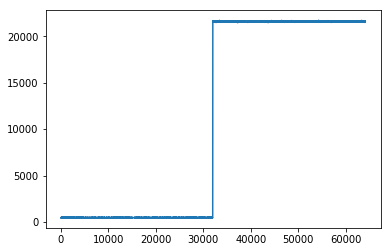

In [37]:
plt.plot(day_df.loc[:, 1])

In [43]:
day_df['ttl_glass_on'] = day_df.loc[:, 1].diff().gt(10000)
day_df['ttl_glass_on'] = day_df.loc[:, 1].diff().le(10000)

In [44]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,ttl_glass_on
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False


In [122]:
import pandas as pd

In [118]:
reload(rd)
meta_dict = rd.read_meta_file(day_files[0])
meta_dict

{'file_type': 'Directed',
 'time_stamp': datetime.datetime(2019, 6, 12, 0, 48, 45, 812500)}

In [104]:
lines_arr = np.array([z.split('\n')[0].strip() for z in file_lines])
lines_arr

array(['filetype:', '{', 'Directed', '}', '', '', 'thresholds activators',
       '{', '2.000000,', '0.500000,', '1.000000,', '2.000000,', '}', '',
       '~D0{}', '', '~D1{}', '', '~D2{}', '', '~D3{}', '', '~D4{}', '',
       '~D5{}', '', '~D6{}', '', '~D7{}', '', '~A0{}', '', '~A1{}', '',
       '~A2{}', '', '~A3{}', '', '~E0{}', '', '~E1{}', '', '*',
       '20190612004845.812500', '*', '+', '501', '+', '', '---', '',
       '3#{250|250|}%{0}${0.035775^0.000000^-1.000583^0.000000^-1.000583^0.000000^-1.000568^3.302421}&{0^0}'],
      dtype='<U99')

In [111]:
t_stamp = lines_arr[np.where(lines_arr=='*')[0] + 1][0]
t_stamp

'20190612004845.812500'

In [112]:
from datetime import datetime

In [114]:
t_obj = datetime.strptime(t_stamp, '%Y%m%d%H%M%S.%f')
t_obj

datetime.datetime(2019, 6, 12, 0, 48, 45, 812500)

In [94]:
file_lines

In [84]:
day_files[0]

'/mnt/microdrive/birds/b11k10/Data/2019-06-12-7061/b11k10D-f00011.lvd'

In [81]:
set_dict

{'hostname': ('ZUFURIOUS',),
 'principal investigator': ('Corinna',),
 'birdname': ('b11k10',),
 'setup': ('ParisE8',),
 'channels': ('PXI1Slot2/ai0',
  'PXI1Slot2/ai1',
  'PXI1Slot2/ao0',
  'PXI1Slot2/ao1'),
 'buffersize': ('128',),
 'scanrate': ('32000.000000',),
 'dynamic range': ('5.000000',),
 'pre [s]': ('1.000000',),
 'post [s]': ('1.000000',),
 'timestamp': ('20190611161058.010',),
 'channel info': ('ParisE8, mic_e8, save true, gain 1.000000',
  'ParisE8, ttl_smartglass, save true, gain 1.000000',
  'ParisE8, trig_rec_e8, save true, gain 1.000000',
  'ParisE8, trig_perc_e8, save true, gain 1.000000'),
 'detector': ({'class': ' detector_harmonics2',
   'name': ' det_harm_e8',
   'AI indices': ' [0||]',
   'note': ' ',
   'meta file parameters': ' '},
  {'class': ' detector_pitch',
   'name': ' det_pitch_e8',
   'AI indices': ' [0||]',
   'note': ' energy minimum: 0.200000, expected pitch: 700.000000, subsample factor: 9.000000',
   'meta file parameters': ' '},
  {'class': ' det

In [68]:
day_hdr

{'hdr_size': 32, 'n_channels': 8, 'sample_rate': 32000.0, 'dynamic_range': 5.0}

In [69]:
day_file.shape

(64128, 8)

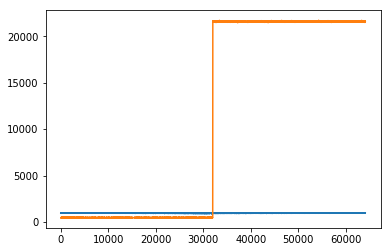

In [70]:
plt.plot(day_file[:, 0])
plt.plot(day_file[:, 1])

In [48]:
pd.DataFrame

NameError: name 'pd' is not defined

In [64]:
day_file.shape[0]/32000

2.5

In [ ]:
# get list of all data files

In [6]:
data_folder

'/mnt/microdrive/birds/g4r4/Data'